<a href="https://colab.research.google.com/github/tedteske/bounded_lognorm/blob/master/bounded_lognorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

The **bounded lognormal** is a continuous probability distribution derived from the [lognormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution). The lognormal probability density function (pdf) is often defined in terms of $\mu_N$ and $\sigma_N$, the mean and standard deviation of some normal distribution $N$:


$$
f_L(x, \mu_N, \sigma_N ) = \frac{1}{x \sigma_N \sqrt{2 \pi}} \times exp(\frac{-(\ln(x) - \mu_N)^2}{2\sigma_N^2}) \tag{1}
$$

If we redefine $f_L$ in terms of mode $m$ and standard deviation $\sigma$ as $f_{L'}$, then the bounded lognormal pdf $f_{BL}$ is the piecewise function:

$$
f_{BL}(x, m, \sigma, upper) =
  \begin{cases}
    f_{L'}(x, m, \sigma)   &  \text{for } x <= m \\
    f_{L'}(upper-x, upper-m, \sigma)   &  \text{for } x > m \\
  \end{cases} \tag{2}
$$

where the second piece is scaled so that $f_{BL}$ is continuous at the mode, and $(lower, upper)$ are the lower and upper bounds of the domain.

### Python Implementation: Class Definition

The bounded lognormal distribution is implemented in Python as an instance of the [scipy.stats.rv_continuous](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous) class and inherits from it a collection of generic methods.

In [28]:
from scipy.stats import rv_continuous
from scipy.integrate import quad, cumtrapz, trapz
from scipy import interpolate
import pandas as pd
import numpy as np

'''
The following optional imports and plotting settings are for the examples 
below, but not necessary for the class definition itself.
'''
from scipy.stats import norm, truncnorm, kurtosis, normaltest
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid') 
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = [10, 10/1.6]
'''
End of optional section.
'''

def lognorm_pdf(x, mu_N, sigma_N):
    '''
    Log-normal (aka lognormal) probability density function.
    
    Parameters
    ----------
    mu_N : float: mean of underlying normal distribution
    sigma_N : float: standard deviation of underlying normal distribution
    
    Returns
    -------
    array of floats
    
    References
    ----------
    [1] https://en.wikipedia.org/wiki/Log-normal_distribution
    '''

    # Creates an index of positive elements in x.       
    i = np.nonzero(x>0)
    
    # Applies lonormal pdf to positive elements. 
    # All others evaluate to 0.
    y = np.zeros(len(x))
    y[i] = 1 / (x[i] * sigma_N * np.sqrt(2 * np.pi)) \
           * np.exp(-(np.log(x[i]) - mu_N)**2 / (2 * sigma_N**2))
    return y


def lognorm_params(mode, sigma):
    '''
    Given user-defined mode and sigma of a lognormal distribution, 
    calculates the mu and sigma of its underlying normal distribution.

    Parameters
    ----------
    mode : float: mode of lognormal distribution
    sigma : float: standard deviation of lognormal distribution
    
    Returns
    -------
    mu_N : float
    sigma_N : float
    
    References
    ----------
    [1] Adapted from Warren Weckesser's ansnwer to 
        https://stackoverflow.com/questions/41464753
    '''
        
    # find the roots of the polynomial
    # g^4 - g^3 - sigma^2/mode^2
    # where g = exp(variance of the associated Normal distribution)
    p = np.poly1d([1, -1, 0, 0, -(sigma/mode)**2])
    r = p.roots 
    
    # just the real, positive root
    solution = r[(r.imag == 0) & (r.real > 0)].real
    
    sigma_N = np.sqrt(np.log(solution))
    mu_N = np.log(mode * solution)
    return mu_N, sigma_N

class bounded_lognorm_gen(rv_continuous):
    '''
    Subclass of scipy.stats.rv_continuous. This is used to generate a
    bounded lognormal continuous probability distribution, which is  fully 
    described by mode, standard deviation (sigma), lower, and upper bounds.

    The probability density function (pdf) concatenates two lognormal pdf:
    1. left-of-mode: lognormal pdf with loc at lower bound, and 
    2. right-of-mode: reversed lognormal pdf with loc at upper bound and 
        scaled so that the concatenated pdf is continuous at the mode.

    Methods
    -------
    same as scipy.stats.rv_continuous
    '''

    def _pdf(self, x, mode, sigma, lower, upper):
        '''
        Probability density function (pdf)

        Parameters
        ----------
        x : float, list or array of floats; x-value(s)
        mode : float; mode
        sigma : float; standard deviation
        lower : float; lower bound 
        upper : float; upper bound 

        Returns
        -------
        relative likelihood [1] of x

        References
        ----------
        [1] https://en.wikipedia.org/wiki/Probability_density_function
        '''

        # shifts x, lower, upper, and mode so that lower is at 0;
        # allows negative x-values 
        x, mode, upper = x - lower, mode - lower, upper - lower
        
        # concatenates left- and right-of-mode pdfs
        y = self.concat_pdf(x, mode, sigma, upper)
        
        # normalizes concatenated pdf to area = 1
        if hasattr(x, "__len__") and len(x) >= 1000:
            scale = trapz(y, x)
        else:    
            scale, _ = quad(lambda j: self.concat_pdf(j, mode, sigma, upper), 
                            0, upper)
        return y / scale
    
    def _cdf(self, x, mode, sigma, lower, upper):
        '''
        Cumulative density function (cdf)
        '''
        x_, y_ = self.discrete_cdf(x, mode, sigma, lower, upper)
        return interpolate.interp1d(x_, y_, axis=0)(x)

    def _ppf(self, p, mode, sigma, lower, upper):
        '''
        Percent point function (ppf), inverse of cdf
        '''
        x_, y_ = self.discrete_cdf(p, mode, sigma, lower, upper)
        return interpolate.interp1d(y_, x_, axis=0, bounds_error=False,
                                    fill_value=(lower, upper))(p) 
             
    def _argcheck(self, *args):
        """
        Overrides default _argcheck to allow negative parameters. Returns 
        condition array of 1s where arguments are correct and 0s where they 
        are not.
        """

        for arg in args:
            cond = np.isfinite(arg)
        return cond
    
    def pdf(self, x, mode, sigma, lower, upper):
        try:
            # converts parameters to scalars, if necessary
            mode, sigma, lower, upper = mode[0], sigma[0], lower[0], upper[0]
        except:
            pass  
        return self._pdf(x, mode, sigma, lower, upper)
    
    def cdf(self, x, mode, sigma, lower, upper):
        return self._cdf(x, mode, sigma, lower, upper)

    def ppf(self, p, mode, sigma, lower, upper):       
        y = np.where(p == 1.0, 
                     upper,
                     self._ppf(p, mode, sigma, lower, upper))
        
        '''
        This is an alternate way, but appears to be slightly slower.
        '''
        '''
        # converts to numpy array if p is a scalar or list
        if not isinstance(p, (pd.core.series.Series, np.ndarray)):
            p = np.array([p])
        
        y = np.zeros(len(p))
        y[p<1] = self._ppf(p[p<1], mode, sigma, lower, upper)
        y[p>=1] = upper
        '''
        return y
    
    def concat_pdf(self, x, mode, sigma, upper):
        '''
        Concatenates left- and right-of-mode pdfs.
        '''
        # converts to numpy array if x is a scalar or list
        if not isinstance(x, (pd.core.series.Series, np.ndarray)):
            x = np.array([x])
       
        # left side
        mu_N_left, sigma_N_left = lognorm_params(mode, sigma)
        x_left = np.append(x[x<=mode], [mode], axis=0)
        y_left = lognorm_pdf(x_left, mu_N_left, sigma_N_left)
        
        # right side
        mu_N_right, sigma_N_right = lognorm_params((upper - mode), sigma)
        x_right = np.append(x[x>mode], [mode], axis=0)
        y_right = lognorm_pdf(upper - x_right, mu_N_right, sigma_N_right)
        
        # scale right side so that left and right sides continuous at mode
        y_right = y_right * (y_left[-1] / y_right[-1]) 
        y = np.append(y_left[:-1], y_right[:-1], axis=0)
        return y
    
    def discrete_cdf(self, x, mode, sigma, lower, upper, min_samples=10000):
        if hasattr(x, "__len__") and len(x) > min_samples:
            min_samples = len(x)
        x_ = np.linspace(lower, upper, min_samples, endpoint=True) 
        x_ = x_.squeeze()
        y = self._pdf(x_, mode, sigma, lower, upper)
        y_ = cumtrapz(y, x_, initial = 0)
        return x_, y_
       
bounded_lognorm = bounded_lognorm_gen(name='bounded_lognorm', 
                                      shapes='mode, sigma, lower, upper')

### Example Usage

#### Function Plots and Histogram

Probability density functions (pdf) with various modes and sigmas, respectively.

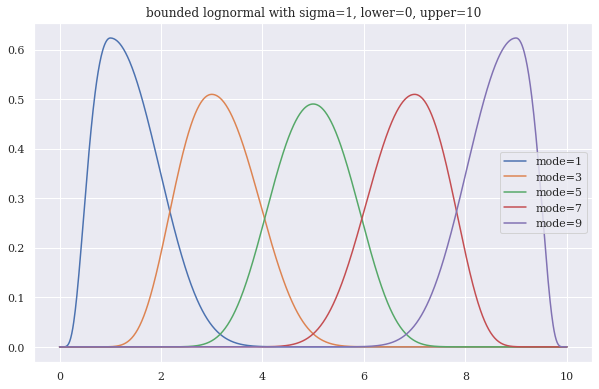

In [29]:
modes = [1, 3, 5, 7, 9]
sigma = 1
lower, upper = 0, 10
x = np.linspace(lower, upper, 1000)

for mode in modes:
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x, y, label='mode=' + str(mode))
plt.title('bounded lognormal with sigma=' + str(sigma) +
          ', lower=' + str(lower) +
          ', upper=' + str(upper))
plt.show()

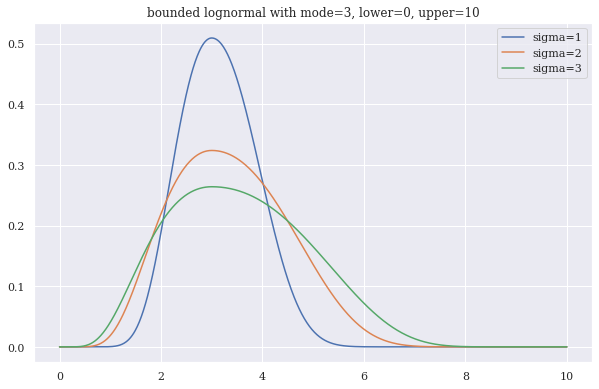

In [30]:
mode = 3
sigmas = [1, 2, 3]
lower, upper = 0, 10
x = np.linspace(lower, upper, 1000)

for sigma in sigmas:
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x, y, label='sigma=' + str(sigma))
plt.title('bounded lognormal with mode=' + str(mode) +
          ', lower=' + str(lower) +
          ', upper=' + str(upper))
plt.show()

Probability density function (pdf) with 95% confidence interval

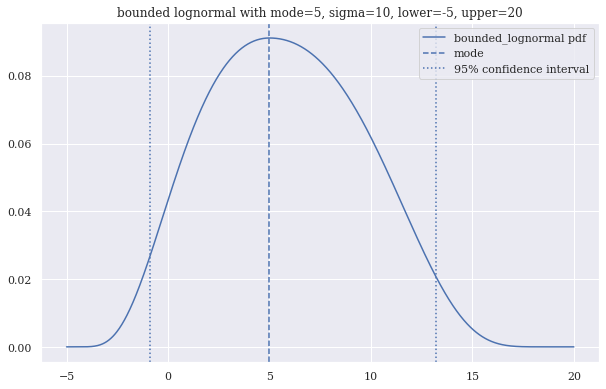

In [31]:
mode, sigma = 5, 10
lower, upper = -5, 20

x = np.linspace(lower, upper, 1000)
y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
sns.lineplot(x, y, label='bounded_lognormal pdf')
plt.axvline(mode, ymin=0, linestyle='dashed', label='mode')

interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
plt.axvline(interval[0], ymin=0, linestyle='dotted', 
            label='95% confidence interval')
plt.axvline(interval[1], ymin=0, linestyle='dotted')
title = ('bounded lognormal with mode=' + str(mode) +
          ', sigma=' + str(sigma) +
          ', lower=' + str(lower) +
          ', upper=' + str(upper))
plt.title(title)
plt.legend()
plt.show()

In [32]:
%timeit -r 3 bounded_lognorm.pdf(x, mode, sigma, lower, upper)

1000 loops, best of 3: 414 µs per loop


Cumulative distribution function (cdf)

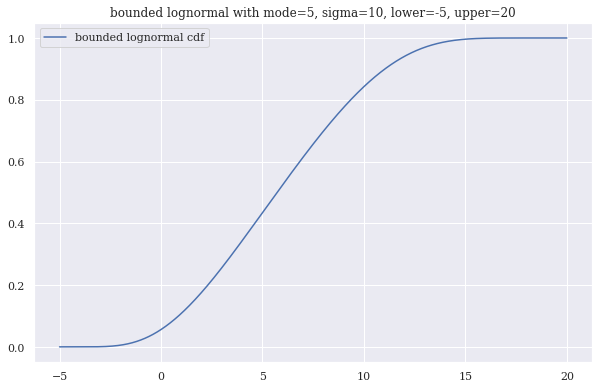

In [33]:
x = np.linspace(lower, upper, 1000)
y = bounded_lognorm.cdf(x, mode, sigma, lower, upper)
sns.lineplot(x, y, label='bounded lognormal cdf')
plt.title(title)
plt.show()

Percent point function (ppf), the inverse of the cdf.

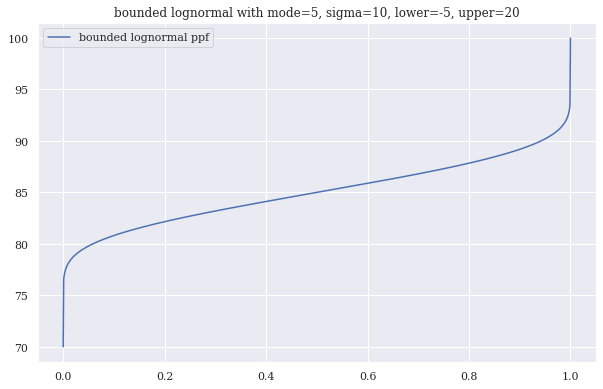

In [34]:
x = np.linspace(0, 1, 1000)
y = bounded_lognorm.ppf(x, mode=85, sigma=5, lower=70, upper=100)
sns.lineplot(x, y, label='bounded lognormal ppf')
plt.title(title)
plt.show()

In [35]:
%timeit bounded_lognorm.ppf(x, mode=85, sigma=5, lower=70, upper=100)

1000 loops, best of 3: 1.55 ms per loop


Print 100 random numbers from this distribution.

In [36]:
bounded_lognorm.rvs(mode=mode, sigma=sigma, lower=lower, upper=upper, size=100)

array([ 7.9158304 ,  1.9375888 ,  2.68030177, -1.82625723,  7.06974321,
        1.98443724,  9.87087518, 13.90952443,  1.59836192,  3.49389739,
        5.11989243,  5.86652245,  7.10594471,  2.73037885,  9.02404279,
        7.53820735,  9.39037228,  2.51658772,  7.35268567,  3.04211562,
        1.51554937, 10.5899633 ,  3.14557062, 11.66790021, 13.24766079,
        2.07212851, -0.06547478,  1.66249702,  8.39198891,  1.44709201,
       13.53136573,  6.81061342,  2.8795117 ,  0.33989458,  9.633729  ,
        5.7430146 , 13.46517626,  5.64661854, -0.02579495,  3.7077373 ,
        4.65509285, -1.59092   ,  5.12845463, -0.78203775,  0.18255749,
        5.24704859,  1.5623728 ,  4.07058798,  1.37685396,  5.12644494,
        2.4542214 , -0.5077621 ,  8.68818184,  6.89615651,  7.61358052,
        7.48717723,  9.65370865,  6.41906702,  3.72490116,  7.27924549,
        3.96686781,  9.83558316,  8.88104035,  5.64635363,  9.5031182 ,
       14.19297995,  3.85624555,  6.37171832,  8.27503555, 11.78

Plot a histogram of 1000 random numbers from this distribution.

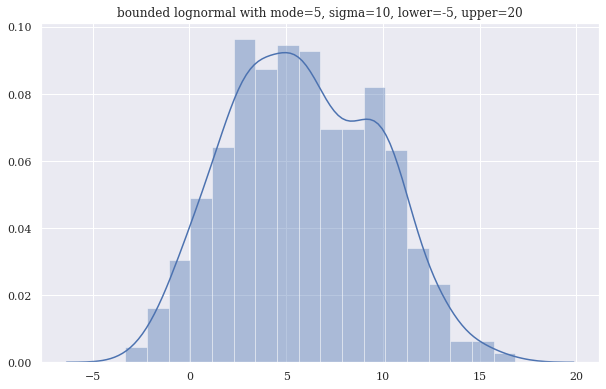

In [37]:
y = bounded_lognorm.rvs(mode=mode, sigma=sigma, lower=lower, upper=upper, 
                        size=1000)
sns.distplot(y)
plt.title(title)
plt.show()

#### Summary Statistics

Median

In [38]:
bounded_lognorm.median(mode, sigma, lower, upper)

array(5.72045175)

Mean

In [39]:
bounded_lognorm.mean(mode, sigma, lower, upper)

5.849409136297276

In [40]:
quad(bounded_lognorm.ppf, 0, 1, args=(mode, sigma, lower, upper))[0]

5.849409136297276

Standard deviation

In [41]:
bounded_lognorm.std(mode, sigma, lower, upper)

3.811695279149043

Note that this is *not* the same as $\sigma$, due to the proximity of the lower and upper domain boundaries. See the section below comparing the bounded lognormal and normal distributions for an illustration.

Central moments

In [42]:
mean, var, skew, kurt = bounded_lognorm.stats(mode, sigma, lower, upper, 
                                              moments='mvsk')
mean, var, skew, kurt 

(array(5.84940914), array(14.5290209), array(0.13655249), array(-0.6632001))

### Derivation

#### From $f_L$ to $f_{L'}$

[Note: The formulas below do not render well in GitHub. If you are viewing this in GitHub, click on the "Open in Colab" link at the top of this page to see them rendered correctly.]

If $\mu_N$ and $\sigma_N^2$ are the mean and variance of some normal distribution $N$, then the mode $m$ and variance $\sigma^2$ of the associated lognormal distribution are 

$$
\begin{align}
       m & = exp(\mu_N - \sigma_N^2) \tag{3} \\\
\sigma^2 & = (exp(\sigma_N^2)-1) \times exp(2\mu_N + \sigma_N ^2) \tag{4}
\end{align}
$$

Letting $g = exp(\sigma_N^2)$ and substituting into equation (4):

$$
\begin{align} 
\sigma^2 & = (g-1) \times exp(2\mu_N + \sigma_N ^2) \\\
         & = (g-1) \times exp(2\mu_N) \times exp(\sigma_N^2) \\\ 
         & = (g-1) \times exp(2\mu_N) \times g \\\
         & = g(g-1) \times exp(2\mu_N)  \tag{5}
\end{align}
$$ 

Rearrangeing equation (3) to solve for $\mu_N$ and plugging into the second expression above:

$$
\begin{align} 
\mu_N & = \ln(m) + \sigma_N^2 \tag{6} \\\ \\\
exp(2\mu_N) & = exp(2(\ln(m)+\sigma_N^2)) \\\
            & = exp(2\ln(m)+2\sigma_N^2) \\\
            & = exp(2\ln(m))+ exp(2\sigma_N^2) \\\
            & = exp(\ln(m))^2+ exp(\sigma_N^2)^2 \\\
            & = m^2g^2 
\end{align}
$$ 

Substituting $m^2g^2$ into equation (5) and rearranging as a quartic equation:

$$
\begin{align} 
\sigma^2 & = g(g-1) \times m^2g^2  \\\
        & = g^3(g-1) \times m^2  \\\
        & = (g^4 - g^3) \times m^2 \\\ \\\
      0 & = g^4 - g^3 -  \sigma^2/m^2 \tag{5}
\end{align}
$$ 

Rearrangeing equation (3) to solve for $\sigma_N$ in terms of $g_r$, the unique positive real root of equation (5):

$$
\sigma_N = \sqrt{\ln(g_r)} \tag{6}
$$

Solving for $\mu_N$ in terms of $g_r$:

$$
\mu_N = \ln(m \times g_r) \tag{7}
$$

Equations (6) and (7) provide the arguments to $f_{L}$.

_References_: 
1. https://en.wikipedia.org/wiki/Log-normal_distribution
2. https://math.stackexchange.com/questions/2003529/derive-mode-of-lognornormal-distribution
3. https://stackoverflow.com/questions/41464753

#### From $f_{L'}$ to $f_{BL}$ in Python

In this section we'll make use of the following functions:
* lognorm_pdf() corresponding to equation (1) above and
* lognorm_params() corresponding to equations (3) through (7) above.

Let's start with an example lognormal pdf with $m = 1$ and $\sigma = 1$. 

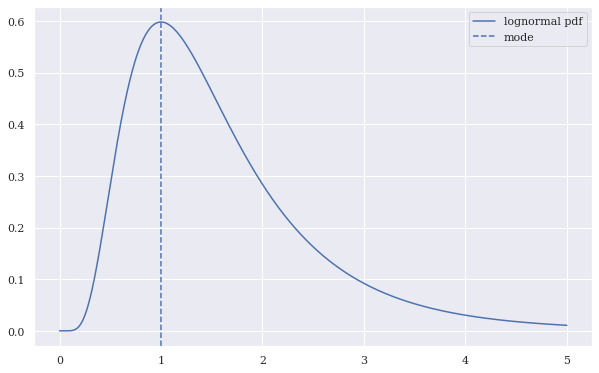

In [43]:
mode, sigma = 1, 1
lower, upper = 0, 5
mu_N, sigma_N = lognorm_params(mode, sigma)

x = np.linspace(lower, upper, 1000)
y = lognorm_pdf(x, mu_N, sigma_N)

sns.lineplot(x, y, label="lognormal pdf")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

Plot just the left-of-mode portion.

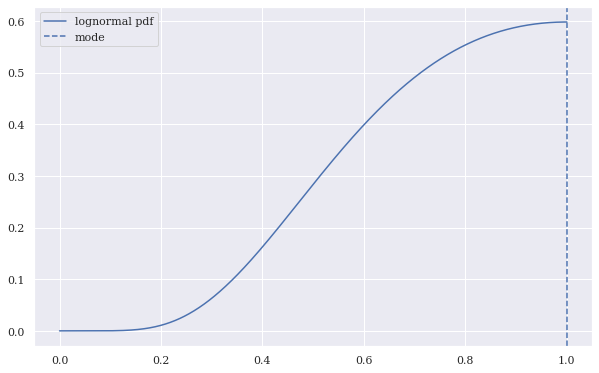

In [44]:
mode, sigma = 1, 1
mu_N, sigma_N = lognorm_params(mode, sigma)

x = np.linspace(lower, mode, 1000)
y = lognorm_pdf(x, mu_N, sigma_N)

sns.lineplot(x, y, label="lognormal pdf")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

Assign, for example, an upper bound of 5. Plot the left-of-mode portion of a lognormal pdf with $m = upper - mode$ and a reversed $x$ values. This is the right-of-mode portion of a new bounded lognormal pdf.

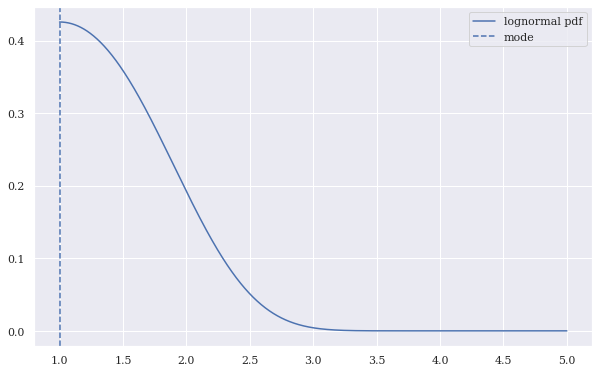

In [45]:
mode, sigma = 1, 1
lower, upper = 0, 5
mu_N, sigma_N = lognorm_params(upper - mode, sigma)

x = np.linspace(mode, upper, 1000)
y = lognorm_pdf(upper - x, mu_N, sigma_N)
sns.lineplot(x, y, label="lognormal pdf")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

Concatenate the left-of-mode and right-of-mode curves above. Notice that they are discontinuous at the mode.

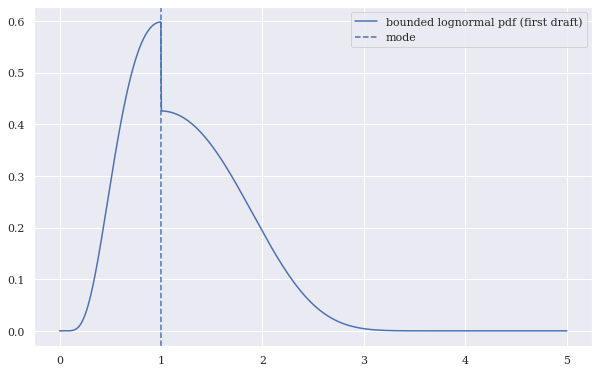

In [46]:
mu_N, sigma_N = lognorm_params(mode, sigma)
x_left = np.linspace(lower, mode, 1000)
y_left = lognorm_pdf(x_left, mu_N, sigma_N)

mu_N, sigma_N = lognorm_params(upper - mode, sigma)
x_right = np.linspace(mode, upper, 1000)
y_right = lognorm_pdf(upper - x_right, mu_N, sigma_N)

x = np.concatenate([x_left, x_right])
y = np.concatenate([y_left, y_right])
sns.lineplot(x, y, label="bounded lognormal pdf (first draft)")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

Scale right side so that left and right sides are continuous at the mode.

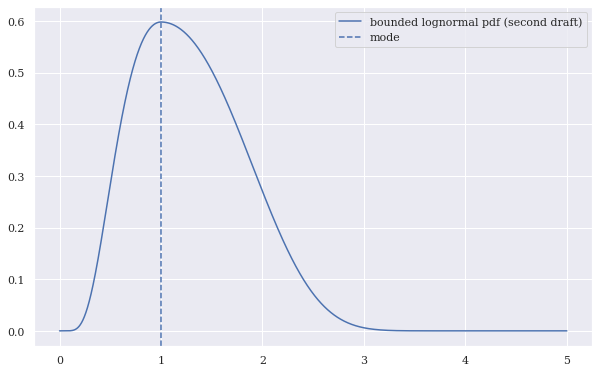

In [47]:
mu_N, sigma_N = lognorm_params(mode, sigma)
x_left = np.linspace(lower, mode, 1000)
x_left = np.append(x_left, [mode], axis=0)
y_left = lognorm_pdf(x_left, mu_N, sigma_N)

mu_N, sigma_N = lognorm_params(upper - mode, sigma)
x_right = np.linspace(mode, upper, 1000)
x_right = np.append(x_right, [mode], axis=0)
y_right = lognorm_pdf(upper - x_right, mu_N, sigma_N)

right_scale =  y_left[-1] / y_right[-1]

y_right = y_right * right_scale

x = np.concatenate([x_left[:-1], x_right[:-1]])
y = np.concatenate([y_left[:-1], y_right[:-1]])
sns.lineplot(x, y, label="bounded lognormal pdf (second draft)")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

What remains in order to use this as a probability density function is to scale the entire curve, so the area under the curve = 1.

### Comparing to the Normal Distribution

In [48]:
def compare_to_standard_N(spread):
    mode, sigma = 0, 1
    lower = mode - spread
    upper = mode + spread

    x = np.linspace(-4, 4, 1000)
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x,y, label='bounded lognormal pdf')

    interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
    plt.axvline(interval[0], ymin=0, linestyle='dashed', 
                label='bounded lognormal 95% conf. interval')
    plt.axvline(interval[1], ymin=0, linestyle='dashed')

    y = norm.pdf(x, loc=mode, scale=sigma)
    sns.lineplot(x,y, label='standard normal pdf')

    interval2 = norm.interval(0.95, loc=mode, scale=sigma)
    plt.axvline(interval2[0], ymin=0, linestyle='dashed', c='red', alpha=0.5,
                label='standard normal 95% conf interval')
    plt.axvline(interval2[1], ymin=0, linestyle='dashed', c='red', alpha=0.5)

    plt.legend()
    plt.show()

As the upper and lower bounds move away from the mode, the bounded lognormal pdf appears to better approximate the normal pdf.

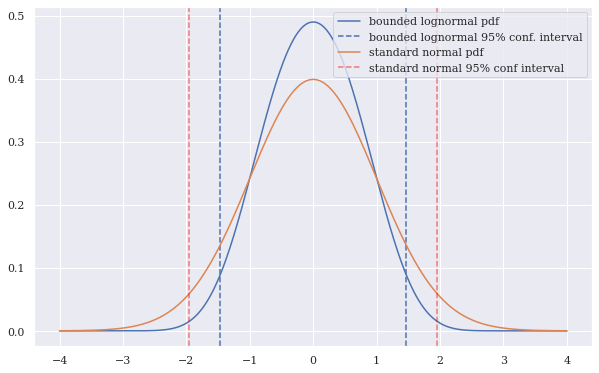

In [49]:
compare_to_standard_N(5)

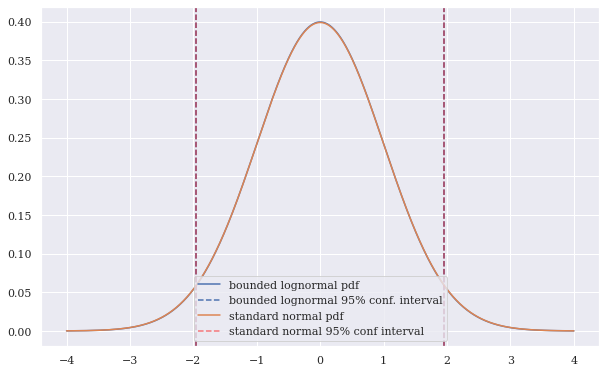

In [50]:
compare_to_standard_N(500)

However, as the spread continues to widen, the confidence intervals diverge. Why?

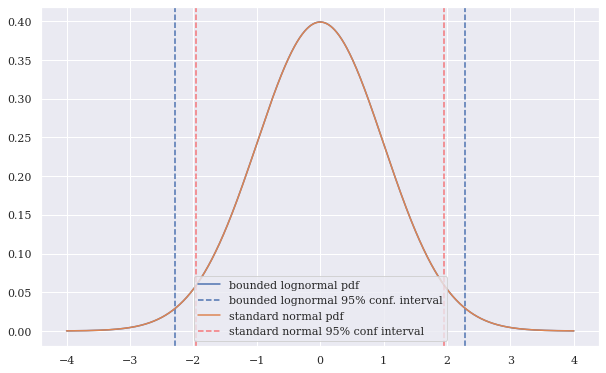

In [51]:
compare_to_standard_N(5000)

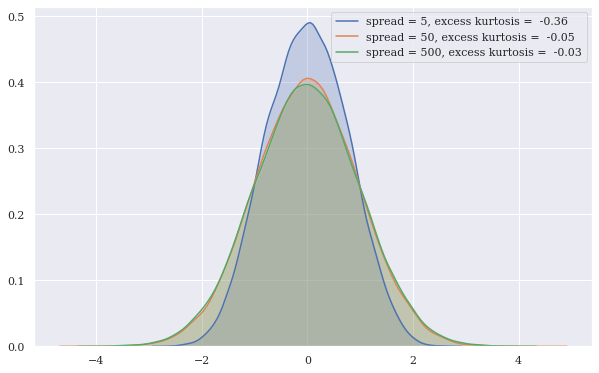

In [52]:
mode, sigma = 0, 1

spreads = [5, 50, 500]
for spread in spreads:

    lower = mode - spread
    upper = mode + spread

    y = bounded_lognorm.rvs(mode, sigma, lower, upper, size=max(spreads)*100)
    k = kurtosis(y, fisher=True)
    label = 'spread = ' + str(spread)
    label += ', excess kurtosis =  ' + str(round(k,2))
    sns.kdeplot(y, label=label, shade=True)
plt.legend()
plt.show()

In [53]:
spread = 1
mode, sigma = 0, 1
lower = mode - spread
upper = mode + spread

x = np.linspace(-4, 4, 1000)
y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)

normaltest(y, axis=0, nan_policy='propagate')

NormaltestResult(statistic=429.5839758928532, pvalue=5.212245677324883e-94)

### Comparing to the Truncated Normal Distribution

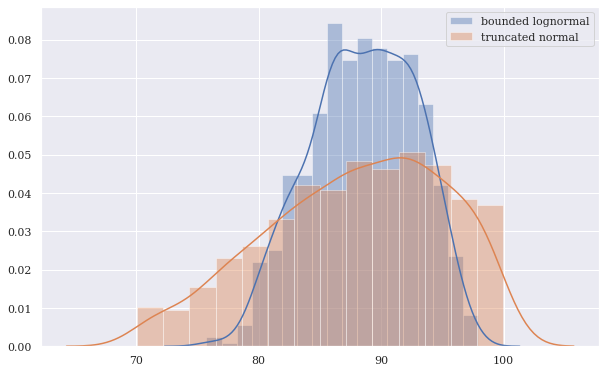

In [54]:
mode, sigma = 90, 10
lower, upper = 70, 100

sns.distplot(bounded_lognorm.rvs(mode=mode, sigma=sigma, 
                                 lower=lower, upper=upper, size=1000),
             label='bounded lognormal')
sns.distplot(truncnorm.rvs((lower - mode) / sigma,  
                           (upper - mode) / sigma,
                           mode, sigma, size=1000),
             label='truncated normal')
plt.legend()
plt.show()